# Anton Melnychuk ECON 3385 - Problem Set 4

February 10th, 2026

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

hausman_data = pd.read_csv("hausman_data.csv")
hausman_data.head()

,city,time,prod,price,qty
0,1,1,1,6.028006,238.995267
1,1,1,2,8.232000,646.243673
2,1,1,3,6.974984,767.854482
3,1,1,4,8.879458,559.638749
4,1,1,5,7.007685,708.385041


## Question 1

Transform the data from long format to wide format, creating separate columns for each product's price and quantity.

In [6]:
hausman_pivot = hausman_data.pivot(
    index=["city", "time"], 
    columns="prod", 
    values=["price", "qty"]
)

# Flatten the multi-level column
hausman_pivot.columns = [
    f'{val}{col}' for val, col in hausman_pivot.columns
]

hausman_pivot = hausman_pivot.reset_index()
hausman_pivot.head()

,city,time,price1,price2,price3,price4,price5,qty1,qty2,qty3,qty4,qty5
0,1,1,6.028006,8.232000,6.974984,8.879458,7.007685,238.995267,646.243673,767.854482,559.638749,708.385041
1,1,2,3.589721,3.884272,3.361197,5.561177,5.595291,490.060439,365.277518,397.480928,538.904913,384.473539
2,1,3,2.891599,4.292659,4.164220,4.983339,7.509970,378.983007,455.782289,532.482876,507.923281,625.442284
3,1,4,4.623883,6.725099,6.297546,6.153429,11.684874,473.928773,712.214672,716.641624,773.906723,724.867135
4,1,5,4.115155,5.619486,4.986857,6.594416,6.705489,302.054122,584.416389,345.371783,800.878089,615.957254


## Question 2

Create Hausman instruments for each product. The Hausman instrument for product $j$ in city $c$ at time $t$ is the average price of product $j$ in all other cities (excluding city $c$) at time $t$.

In [7]:
# want average price of each product in other cities at same time

products = [1, 2, 3, 4, 5]
n_cities = 20

for prod in products:
    own_price = f'price{prod}'
    instrument_name = f'otherprice{prod}'
    
    # total sum minus own city price, then divide by number of cities
    total_by_time = hausman_pivot.groupby('time')[own_price].transform('sum')
    hausman_pivot[instrument_name] = (total_by_time - hausman_pivot[own_price]) / n_cities

hausman_pivot.head()

,city,time,price1,price2,price3,price4,price5,qty1,qty2,qty3,qty4,qty5,otherprice1,otherprice2,otherprice3,otherprice4,otherprice5
0,1,1,6.028006,8.232000,6.974984,8.879458,7.007685,238.995267,646.243673,767.854482,559.638749,708.385041,4.958237,5.850381,4.912617,7.834712,7.027399
1,1,2,3.589721,3.884272,3.361197,5.561177,5.595291,490.060439,365.277518,397.480928,538.904913,384.473539,3.419166,4.979187,4.739280,5.852452,7.708621
2,1,3,2.891599,4.292659,4.164220,4.983339,7.509970,378.983007,455.782289,532.482876,507.923281,625.442284,3.153736,4.712567,4.249908,5.655968,7.076983
3,1,4,4.623883,6.725099,6.297546,6.153429,11.684874,473.928773,712.214672,716.641624,773.906723,724.867135,4.129611,5.079886,5.095420,5.478766,8.946842
4,1,5,4.115155,5.619486,4.986857,6.594416,6.705489,302.054122,584.416389,345.371783,800.878089,615.957254,4.109981,4.497316,5.285273,5.555685,6.770103


In [8]:
hausman_pivot[["city"]].nunique()

city    20
dtype: int64

## Question 3

### a) Linear Demand Equation

$$Q_{jct}^{D} = \alpha_{jc} + \sum_{k=1}^{K} \beta_{jk} P_{kct} + \varepsilon_{jct}^{D}$$

- $Q_{jct}^{D}$ = how much of product $j$ people want to buy in city $c$ at time $t$
- $\alpha_{jc}$ = baseline demand for product $j$ in city $c$ (some cities just like certain products more)
- $\beta_{jk}$ = how sensitive demand is to prices
- $P_{kct}$ = price of product $k$ in city $c$ at time $t$
- $\varepsilon_{jct}^{D}$ = random demand shocks (things we can't observe that affect demand)

### b) Marginal Cost Specification

When firms maximize profits, they set prices where marginal revenue equals marginal cost:

$$p_{jct} \cdot \frac{\partial Q_{jct}}{\partial p_{jct}} + Q_{jct} = MC_{jct} \cdot \frac{\partial Q_{jct}}{\partial p_{jct}}$$

$$MC_{jct} = p_{jct} + \frac{Q_{jct}}{\frac{\partial Q_{jct}}{\partial p_{jct}}}$$

For linear demand $Q_{jct} = \alpha_{jc} + \sum_{k=1}^{J} \beta_{jk} P_{kct}$, the derivative with respect to own price is:

$$\frac{\partial Q_{jct}}{\partial p_{jct}} = \beta_{jj}$$

Since $\beta_{jj} < 0$, raising price lowers demand.

Substitute into the marginal cost equation:

$$MC_{jct} = p_{jct} + \frac{Q_{jct}}{\beta_{jj}}$$

Marginal cost = price + markup

### (c) Assumptions for Hausman Instruments Validity

The Hausman instrument for product $j$ in city $c$ at time $t$ is:

$$p_{jct}^{Z} = \frac{1}{C-1} \sum_{c' \neq c} P_{jc't}$$

Where $C$ is the total number of cities.

**Relevance Condition:** The instrument must be correlated with the endogenous variable (own price). This holds because:
- Prices across cities are correlated due to common cost shocks, market conditions, or competitive forces

**Exclusion Restriction:** The instrument must affect quantity demanded only through its effect on own price, not directly. This requires:
- demand shocks in city $c$ do not affect prices in other cities $c'$
- city-specific demand shocks ($\varepsilon_{jct}^{D}$) are uncorrelated across cities
- price differences across cities reflect supply-side factors rather than demand-side factors

**Exogeneity:** The instrument is uncorrelated with the error term $\varepsilon_{jct}^{D}$.

## Question 4

Estimate 5 demand equations using Two-Stage Least Squares (2SLS).

For each product, we regress quantity on all prices, using Hausman instruments.

In [10]:
from statsmodels.sandbox.regression.gmm import IV2SLS

price_vars = ['price1', 'price2', 'price3', 'price4', 'price5']
instrument_vars = ['otherprice1', 'otherprice2', 'otherprice3', 'otherprice4', 'otherprice5']

demand_models = {}

# estimate demand for each product
for prod in range(1, 6):
    y = hausman_pivot[f'qty{prod}']
    # endogenous regressors
    X_endog = sm.add_constant(hausman_pivot[price_vars])
    # Hausman instruments for all prices
    Z = sm.add_constant(hausman_pivot[instrument_vars])
    
    model = IV2SLS(y, X_endog, Z).fit()
    demand_models[f'product_{prod}'] = model

In [14]:
print(demand_models[f'product_{1}'].summary())

                          IV2SLS Regression Results                           
Dep. Variable:                   qty1   R-squared:                      -0.840
Model:                         IV2SLS   Adj. R-squared:                 -0.855
Method:                     Two Stage   F-statistic:                     27.44
                        Least Squares   Prob (F-statistic):           5.10e-25
Date:                Tue, 10 Feb 2026                                         
Time:                        01:40:10                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        686.8071    184.419      3.724      0.0

In [15]:
print(demand_models[f'product_{2}'].summary())

                          IV2SLS Regression Results                           
Dep. Variable:                   qty2   R-squared:                      -1.643
Model:                         IV2SLS   Adj. R-squared:                 -1.665
Method:                     Two Stage   F-statistic:                     5.425
                        Least Squares   Prob (F-statistic):           6.85e-05
Date:                Tue, 10 Feb 2026                                         
Time:                        01:40:17                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        791.0331    184.426      4.289      0.0

In [16]:
print(demand_models[f'product_{3}'].summary())

                          IV2SLS Regression Results                           
Dep. Variable:                   qty3   R-squared:                      -0.600
Model:                         IV2SLS   Adj. R-squared:                 -0.614
Method:                     Two Stage   F-statistic:                     37.08
                        Least Squares   Prob (F-statistic):           4.20e-33
Date:                Tue, 10 Feb 2026                                         
Time:                        01:40:22                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        874.2595    183.880      4.755      0.0

In [17]:
print(demand_models[f'product_{4}'].summary())

                          IV2SLS Regression Results                           
Dep. Variable:                   qty4   R-squared:                      -0.961
Model:                         IV2SLS   Adj. R-squared:                 -0.978
Method:                     Two Stage   F-statistic:                     10.08
                        Least Squares   Prob (F-statistic):           2.80e-09
Date:                Tue, 10 Feb 2026                                         
Time:                        01:40:27                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        862.0068    168.223      5.124      0.0

In [18]:
print(demand_models[f'product_{5}'].summary())

                          IV2SLS Regression Results                           
Dep. Variable:                   qty5   R-squared:                      -0.891
Model:                         IV2SLS   Adj. R-squared:                 -0.907
Method:                     Two Stage   F-statistic:                     20.17
                        Least Squares   Prob (F-statistic):           1.30e-18
Date:                Tue, 10 Feb 2026                                         
Time:                        01:40:31                                         
No. Observations:                 600                                         
Df Residuals:                     594                                         
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        963.2208    173.152      5.563      0.0

## Question 5

Calculate the elasticity matrix. The elasticity of quantity $j$ with respect to price $k$ is:

$$\varepsilon_{jk} = \beta_{jk} \times \frac{\bar{P}_k}{\bar{Q}_j}$$

In [22]:
# calculate average prices and quantities
price_cols = ['price1', 'price2', 'price3', 'price4', 'price5']
qty_cols = ['qty1', 'qty2', 'qty3', 'qty4', 'qty5']

P_bar = np.array([hausman_pivot[col].mean() for col in price_cols]) 
Q_bar = np.array([hausman_pivot[col].mean() for col in qty_cols])

In [24]:
# extract coefficients from demand models
B = np.zeros((5, 5))

for i in range(5):
    model = demand_models[f'product_{i+1}']
    for j, price_var in enumerate(price_vars):
        if price_var in model.params.index:
            B[i, j] = model.params[price_var]
        else:
            B[i, j] = 0

print(B.round(4))

[[-155.7746   20.005    16.4413    1.6614   21.5251]
 [  14.8583  -99.7369   17.3388   20.1118   -3.7507]
 [   5.0519   52.3294 -132.0943  -12.3873   16.7322]
 [   8.6417   66.5466   11.962  -115.8626   11.1725]
 [  26.8079   -4.2221   38.0241   22.172   -96.8683]]


In [26]:
# elasticity matrix
# ε_ij = β_ij × (P_j / Q_i)
elasticity_matrix = np.zeros((5, 5))

for i in range(5):  # quantity (row)
    Q_i_mean = Q_bar[i]
    for j in range(5):  # price (column)
        P_j_mean = P_bar[j]
        beta_ij = B[i, j]

        elasticity_matrix[i, j] = beta_ij * (P_j_mean / Q_i_mean)

elasticity_df = pd.DataFrame(
    elasticity_matrix,
    index=[f'Q{i+1}' for i in range(5)],
    columns=[f'P{j+1}' for j in range(5)]
)

print("Elasticity Matrix:")
print(elasticity_df.round(4))

Elasticity Matrix:
        P1      P2      P3      P4      P5
Q1 -1.5765  0.2731  0.2143  0.0255  0.3970
Q2  0.1281 -1.1600  0.1925  0.2628 -0.0589
Q3  0.0398  0.5563 -1.3408 -0.1479  0.2403
Q4  0.0523  0.5430  0.0932 -1.0620  0.1232
Q5  0.1696 -0.0360  0.3097  0.2125 -1.1166


## Question 6

Positive values (off-diagonal entries) here mean that products are substitutes: if product $j$'s price rises (column $j$), demand for product $i$ increases (row $i$). The bigger the positive number, the stronger the substitution effect.

The strongest substitute relationships:
- Q3 with respect to P2: 0.5563 — Product 3 is a substitute for Product 2
- Q4 with respect to P2: 0.5430 — Product 4 is a substitute for Product 2
- Q1 with respect to P5: 0.3970 — Product 1 is a substitute for Product 5
- Q5 with respect to P3: 0.3097 — Product 5 is a substitute for Product 3
- Q1 with respect to P2: 0.2731 — Product 1 is a substitute for Product 2
- Q2 with respect to P4: 0.2628 — Product 2 is a substitute for Product 4
- Q3 with respect to P5: 0.2403 — Product 3 is a substitute for Product 5
- Q1 with respect to P3: 0.2143 — Product 1 is a substitute for Product 3
- Q5 with respect to P4: 0.2125 — Product 5 is a substitute for Product 4

## Question 7

Calculate marginal costs for each product using the formula derived in Question 3b:

$$MC_{jct} = p_{jct} + \frac{Q_{jct}}{\beta_{jj}}$$

In [37]:
B_inv = np.linalg.inv(B)

prices = hausman_pivot[['price1', 'price2', 'price3', 'price4', 'price5']].values
quantities = hausman_pivot[['qty1', 'qty2', 'qty3', 'qty4', 'qty5']].values

# MC = P + Q @ B_inv.T
marginal_costs = prices + (quantities @ B_inv.T)
hausman_pivot['MC1'] = marginal_costs[:, 0]

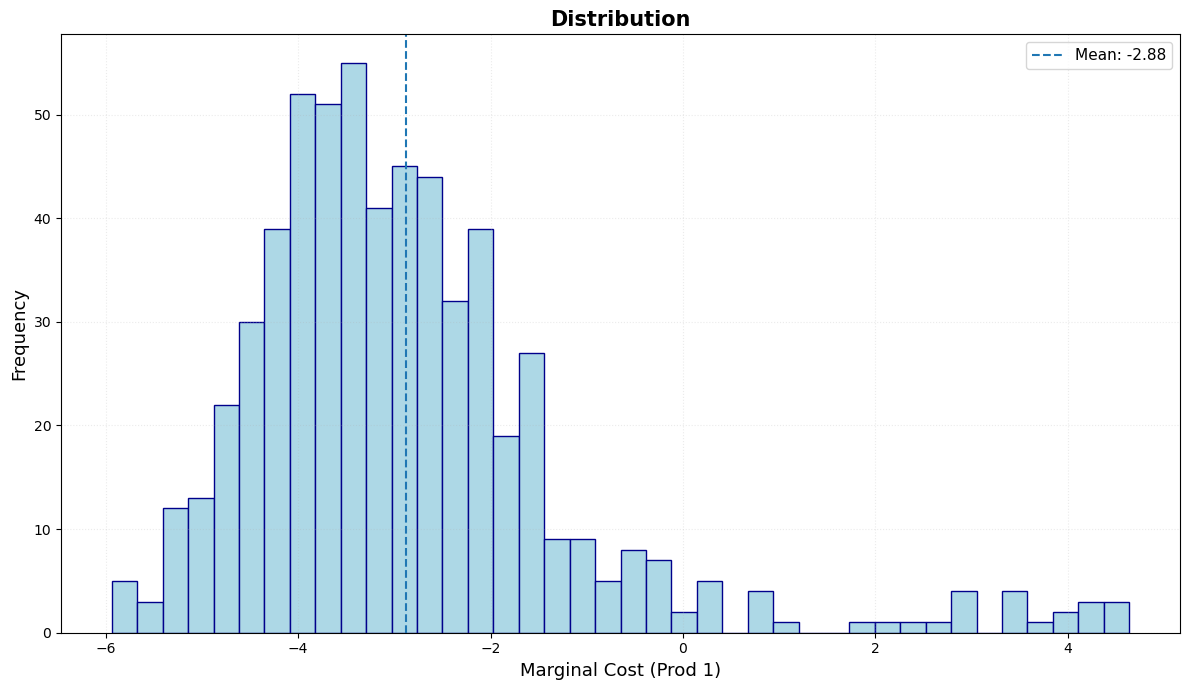


Marginal Cost:
Mean: -2.8778
Std Dev: 1.7270
Min: -5.9379
Max: 4.6408


In [50]:
plt.figure(figsize=(12, 7))
plt.hist(hausman_pivot['MC1'], bins=40, edgecolor='darkblue',color='lightblue')
plt.xlabel('Marginal Cost (Prod 1)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution', fontsize=15, fontweight='bold')
plt.axvline(hausman_pivot['MC1'].mean(), linestyle='--',
            label=f'Mean: {hausman_pivot["MC1"].mean():.2f}')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.25, linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nMarginal Cost:")
print(f"Mean: {hausman_pivot['MC1'].mean():.4f}")
print(f"Std Dev: {hausman_pivot['MC1'].std():.4f}")
print(f"Min: {hausman_pivot['MC1'].min():.4f}")
print(f"Max: {hausman_pivot['MC1'].max():.4f}")